# Exercise sheet

Some general remarks about the exercises:
* For your convenience functions from the lecture are included below. Feel free to reuse them without copying to the exercise solution box.
* For each part of the exercise a solution box has been added, but you may insert additional boxes. Do not hesitate to add Markdown boxes for textual or LaTeX answers (via `Cell > Cell Type > Markdown`). But make sure to replace any part that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove the `raise NotImplementedError()`.
* Please make your code readable by humans (and not just by the Python interpreter): choose informative function and variable names and use consistent formatting. Feel free to check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).
* Make sure that the full notebook runs without errors before submitting your work. This you can do by selecting `Kernel > Restart & Run All` in the jupyter menu.
* For some exercises test cases have been provided in a separate cell in the form of `assert` statements. When run, a successful test will give no output, whereas a failed test will display an error message.
* Each sheet has 100 points worth of exercises. Note that only the grades of sheets number 2, 4, 6, 8 count towards the course examination. Submitting sheets 1, 3, 5, 7 & 9 is voluntary and their grades are just for feedback.

Please fill in your name here:

In [1]:
NAME = "Kees van Kempen"
NAMES_OF_COLLABORATORS = ""

---

**Exercise sheet 5**

Code from the lectures:

In [2]:
import numpy as np
import matplotlib.pylab as plt

rng = np.random.default_rng()
%matplotlib inline

def sample_autocovariance(x,tmax):
    '''Compute the sample autocorrelation of the time series x 
    for t = 0,1,...,tmax-1.'''
    x_shifted = x - np.mean(x)
    return np.array([np.dot(x_shifted[:len(x)-t],x_shifted[t:])/(len(x)-t) 
                     for t in range(tmax)])

def find_correlation_time(autocov):
    '''Return the index of the first entry that is smaller than autocov[0]/e or the length of autocov if none are smaller.'''
    smaller = np.where(autocov < np.exp(-1)*autocov[0])[0]
    return smaller[0] if len(smaller) > 0 else len(autocov)

# Ising model
def attempt_spin_flip_for_trace(config,boltzmannfactor):
    '''Perform Metropolis-Hastings transition on config and return
    change in magnetization and energy.'''
    w = len(config)
    i,j = rng.integers(0,w,2)
    neighbour_sum = config[i,j] * (config[(i+1)%w,j] + config[(i-1)%w,j] + 
                                   config[i,(j+1)%w] + config[i,(j-1)%w])
    if neighbour_sum <= 0 or rng.random() < boltzmannfactor**neighbour_sum:
        config[i,j] = -config[i,j]
        return 2*config[i,j], 2*neighbour_sum
    else:
        return 0, 0
    
def compute_energy(config):
    '''Compute the energy H(s) of the state config (with J=1).'''
    h = 0
    w = len(config)
    for i in range(w):
        for j in range(w):
            h -= config[i,j] * (config[i,(j+1)%w] + config[(i+1)%w,j])
    return h

def compute_magnetization(config):
    '''Compute the magnetization M(s) of the state config.'''
    return np.sum(config)
        
def get_MCMC_trace(config,beta,n):
    '''Sample first n steps of the Markov chain and produce trace
    of magnetization and energy.'''
    boltz = np.exp(-2*beta)
    trace = np.zeros((n,2))
    # set the initial magnetization and energy ...
    m = compute_magnetization(config)
    h = compute_energy(config)
    for i in range(n):
        dm, dh = attempt_spin_flip_for_trace(config,boltz)
        # ... and update them after each transition
        m += dm
        h += dh
        trace[i][0] = m
        trace[i][1] = h
    return trace

def uniform_init_config(width):
    '''Produce a uniform random configuration.'''
    return 2*rng.integers(2,size=(width,width))-1

def aligned_init_config(width):
    '''Produce an all +1 configuration.'''
    return np.ones((width,width),dtype=int)

def antialigned_init_config(width):
    '''Produce a checkerboard configuration'''
    if width % 2 == 0:
        return np.tile([[1,-1],[-1,1]],(width//2,width//2))
    else:
        return np.tile([[1,-1],[-1,1]],((width+1)//2,(width+1)//2))[:width,:width]

def plot_ising(config,ax,title):
    '''Plot the Ising configuration.'''
    ax.matshow(config, vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    
def attempt_spin_flip(config,boltzmannfactor):
    '''Perform Metropolis-Hastings transition on config.'''
    w = len(config)
    i,j = rng.integers(0,w,2)
    neighbour_sum = config[i,j] * (config[(i+1)%w,j] + config[(i-1)%w,j] + 
                                   config[i,(j+1)%w] + config[i,(j-1)%w])
    if neighbour_sum <= 0 or rng.random() < boltzmannfactor**neighbour_sum:
        config[i,j] = -config[i,j]

def run_ising_MCMC(config,beta,n):
    '''Perform n steps of the MH Markov chain on config.'''
    boltz = np.exp(-2*beta)
    for _ in range(n):
        attempt_spin_flip(config,boltz)
        
def batch_estimate(data,observable,k):
    '''Devide data into k batches and apply the function observable to each.
    Returns the mean and standard error.'''
    batches = np.reshape(data,(k,-1))
    values = np.apply_along_axis(observable, 1, batches)
    return np.mean(values), np.std(values)/np.sqrt(k-1)

def jackknife_batch_estimate(data,observable,k):
    '''Devide data into k batches and apply the function observable to each 
    collection of all but one batches. Returns the mean and corrected 
    standard error.'''
    batches = np.reshape(data,(k,-1))
    values = [observable(np.delete(batches,i,0).flatten()) for i in range(k)]
    return np.mean(values), np.sqrt(k-1)*np.std(values)

## Storing and loading data in HDF5 files

**(20 points)**

While working on the previous exercises, you may have noticed that it can be impractical to have generated data only available during an active jupyter session. If you loose connection with the python kernel or wish to continue your calculation at a later time, there was no other option than to regenerate the data. From this week on, the computing time involved in generating data will generally increase, making these issues worse. Not just for you, but also for the (auto)grading of your exercise sheets. So we need a method to store and load data, which is the topic of this warm-up exercise. Of course, this will also be very relevant for managing your research project at the end of the course. 

There are many different file formats that one can use to store data: [CSV](https://en.wikipedia.org/wiki/Comma-separated_values), [JSON](https://en.wikipedia.org/wiki/JSON), [YAML](https://en.wikipedia.org/wiki/YAML). We will make use of a file format that is well adapted to handling and organizing (large) numerical data sets: [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format). Python has a convenient package [h5py](https://docs.h5py.org/en/stable/) to read and write hdf5-files. The basic usage is demonstrated in the following code snippet, that stores randomly generated data in a file `test.hdf5`, which will appear in the same directory as this notebook, and reads it again.

In [3]:
import h5py

# generate some floating point test data as Numpy array
testarray = rng.random(1000)
print("testarray[325] =",testarray[325])

# open test.hdf5 for writing (note that if the file already exists, it will be overwritten)
with h5py.File('test.hdf5','w') as f:
    # add the test data as a new data set to the file
    f.create_dataset("test",data=testarray)
    
# open test.hdf5 for reading
with h5py.File('test.hdf5','r') as f:
    # we can directly access some numbers
    print('f["test"][325] =',f["test"][325])
    # or retrieve the full Numpy array
    test = f["test"][()]
    print('test[325] =',test[325])
    
# open test.hdf5 for updating (creating an empty file if it does not yet exist)
with h5py.File('test.hdf5','a') as f:
    # add another data set
    f.create_dataset("test-plus-one",data=testarray+1)
    print('f["test-plus-one"][325] =',f["test-plus-one"][325])
    
# open test.hdf5 for reading
with h5py.File('test.hdf5','r') as f:
    print('f["test"][325] =',f["test"][325])
    print('f["test-plus-one"][325] =',f["test-plus-one"][325])
    
# we can delete a data set from the file as follows
with h5py.File('test.hdf5','a') as f:
    print( "data sets in test.hdf5:", list(f.keys()) )
    del f["test"]
    print( "data sets in test.hdf5:", list(f.keys()) )

testarray[325] = 0.13910269568464984
f["test"][325] = 0.13910269568464984
test[325] = 0.13910269568464984
f["test-plus-one"][325] = 1.1391026956846497
f["test"][325] = 0.13910269568464984
f["test-plus-one"][325] = 1.1391026956846497
data sets in test.hdf5: ['test', 'test-plus-one']
data sets in test.hdf5: ['test-plus-one']


**(a)** Write code that opens the file `test.hdf5` and checks whether the data set `random-walk` is present. If not, generate a random walk $X_0=0,X_1,\ldots,X_{1000}$ with $1000$ steps starting at $0$ with increments that are distibuted as a standard normal random variables, and store $X_0,X_1,\ldots,X_{1000}$ in the data set `random-walk`. **(10 pts)**

In [4]:
# When debugging it is useful to erase the data first:
# with h5py.File('test.hdf5','a') as f:
#     if "random-walk" in f:
#         del f["random-walk"]

with h5py.File('test.hdf5','a') as f:
    if not "random-walk" in f:
        N = 1000
        f.create_dataset("random-walk",data=np.cumsum(np.concatenate([[0.], rng.normal(size=N)])))

In [5]:
with h5py.File('test.hdf5','r') as f:
    assert "random-walk" in f
    assert len(f["random-walk"]) == 1001

**(b)** Write code that reads the file `test.hdf5` and produces a plot of the random walk, so $X_i$ versus $i$ for $i=0,\ldots,1000$. **(10 pts)**

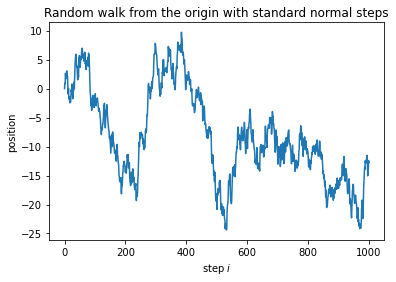

In [6]:
with h5py.File('test.hdf5','r') as f:
    assert "random-walk" in f
    
    N = len(f["random-walk"])
    
    plt.figure()
    plt.plot(np.arange(N), np.array(f["random-walk"]))
    plt.xlabel("step $i$")
    plt.ylabel("position")
    plt.title("Random walk from the origin with standard normal steps")
    plt.show()

## Exploring the 2D Ising model 

**(80 points)**

The goal of this exercise is to get a robust measurement of the magnetization with error bars of the 2D Ising model on a $12\times 12$ grid and the following range of temperatures $T \in [1,4]$. We will work with units where $\beta = 1/T$ (so $k_{\mathrm{B}} = 1$).

In [ ]:
temperatures = np.linspace(1.5,3.5,21)
width = 12
nsites = width*width
print(temperatures)

__(a)__ The first goal is to estimate equilibration times. Write a function `time_until_magnetizations_converge` that starts two Markov chains $X^{\mathrm{a}}_i$ and $X^{\mathrm{u}}_i$ based on the Metropolis-Hastings spin flip algorithm, one with fully aligned initial state $X^{\mathrm{a}}_0$ and one with uniform random initial state $X^{\mathrm{u}}_0$. Return the first time $t$ when the absolute magnetization of the first drops below that of the second, i.e. $t = \inf\{ i : |M(X^{\mathrm{a}}_i)| < |M(X^{\mathrm{u}}_i)| \}$. _Hint_: you may use `attempt_spin_flip_for_trace`. **(10 pts)**

In [ ]:
def time_until_magnetizations_converge(width,beta):
    '''Sample two Markov chains simultaneously, one started in an aligned state 
    and one in a uniform one. Return the first time (in steps) at which the 
    absolute magnetization of the first drops below the second.'''
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
from nose.tools import assert_almost_equal
assert time_until_magnetizations_converge(3,0.2) > 0
assert_almost_equal(np.mean([time_until_magnetizations_converge(3,0.2) for _ in range(500)]),17.7,delta=1.2)
assert_almost_equal(np.mean([time_until_magnetizations_converge(3,0.45) for _ in range(500)]),59,delta=7)

__(b)__ For each of the temperatures $T$ and $w=12$ collect the $10$ the results of `time_until_magnetizations_converge` and store it in a data set named `"eq-times"` in the file `ising_data.hdf5` (as an array of dimension 21 x 10). Make a plot of the average time with error bars as function of the temperature, based on this data in `ising_data.hdf5`. **(15 pts)**

In [ ]:
with h5py.File('ising_data.hdf5','a') as f:
    if not "eq-times" in f:
        # produce and store data
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
with h5py.File('ising_data.hdf5','r') as f:
    # read data in produce plot
    # YOUR CODE HERE
    raise NotImplementedError()

__(c)__ Write a function `estimate_ising_autocorrelation_time` that estimates the autocorrelation time $\tau_{|M|} = \inf\{t:\bar{\rho}(t) < 1/ e\}$ of the absolute magnetization using $q$ steps of equilibration, started from the uniform random initial state, followed by collecting a trace of $n$ steps and a maximal time difference in the sample autocovariance of $t=t_{\mathrm{max}}$. You may use the functions `get_MCMC_trace`, `sample_autocovariance` and `find_correlation_time`. **(10 pts)**

In [ ]:
def estimate_ising_autocorrelation_time(width,beta,q,n,tmax):
    '''Estimate the autocorrelation time using q steps of equilibration followed
    by collecting a trace of n steps, calculating the autocovariance up to t=tmax < n.'''
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert_almost_equal(np.mean([estimate_ising_autocorrelation_time(3,0.2,100,400,20) for _ in range(50)]),7.2,delta=0.7)
assert_almost_equal(np.mean([estimate_ising_autocorrelation_time(3,0.45,100,400,40) for _ in range(50)]),15.2,delta=2.5)

__(d)__ For each of the temperatures $T$ and $w=12$ collect the result of `estimate_ising_autocorrelation_time` using sensible equilibration (use your findings in part b) and trace length and store it in a data set named `"autocorr-times"` in the file `ising_data.hdf5` (as an array of dimension 21). Make a plot of the autocorrelation time (without error bars) as function of the temperature. **(15 pts)**

In [ ]:
with h5py.File('ising_data.hdf5','a') as f:
    if not "autocorr-times" in f:
        # produce and store data
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
with h5py.File('ising_data.hdf5','r') as f:
    # read and plot data
    # YOUR CODE HERE
    raise NotImplementedError()

__(e)__ Finally we can get to our estimate of the mean absolute magnetization $\mathbb{E}[|M(X)|]$. Write a function `sample_magnetizations` that produces $n$ magnetization measurements, using $q$ equilibration sweeps and $k$ sweeps between measurements (thinning). Store $n=1000$ measurements for each temperature $T$ in a data set  `"magnetizations"` in the file `ising_data.hdf5` with appropriate choices for $q$ and $k$. Plot the resulting estimate of $\mathbb{E}[|M(X)|]$ as function of $T$ with error bars. You may use `run_ising_MCMC` and `compute_magnetization`, `batch_estimate`, `jackknife_batch_estimate`. **(20 pts)**

In [ ]:
def sample_magnetizations(width,beta,q,k,n):
    '''Run the Ising model simulation with q equilibration sweeps, k sweeps between measurements, 
    and performing a total of n measurements of the absolute magnetization, which are returned as
    NumPy array.'''
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert_almost_equal(np.mean(sample_magnetizations(3,0.3,50,1,400)),5.72,delta=0.6)
assert_almost_equal(np.mean(sample_magnetizations(3,0.6,50,1,400)),8.72,delta=0.2)

In [ ]:
with h5py.File('ising_data.hdf5','a') as f:
    if not "magnetizations" in f:
        # collect and store data
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
with h5py.File('ising_data.hdf5','r') as f:
    # read and plot
    # YOUR CODE HERE
    raise NotImplementedError()

__(f)__ Produce a plot with error bars of the magnetic susceptibility $\chi = \frac{\beta}{N} \operatorname{Var}(|M(X)|)$ as function of temperature, using the same data set. Apply the jackknife batch estimate for the errors. **(10 pts)**

In [ ]:
with h5py.File('ising_data.hdf5','r') as f:
    # YOUR CODE HERE
    raise NotImplementedError()